# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import chess.pgn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Read the data

In [3]:
white = pd.read_csv('Data/games_as_white_final.csv')
black = pd.read_csv('Data/games_as_black_final.csv')
all_games = pd.read_csv('Data/all_games_final.csv')

In [4]:
white.head(5)

,White,WhiteElo,Result,Black,BlackElo,TimeControl,Date_clean,CurrentPosition,Termination,mainline_moves
0,snAp_freAk,1257,1-0,RobertV44,1220,2m+1s,2024-02-03,1k1rr3/p1pb3p/B5p1/5p2/3Pp3/p3P1P1/KPQ2PP1/1N1...,snAp_freAk won by resignation,1. d4 e6 2. Bf4 d5 3. Nf3 Bd6 4. Bg3 Nc6 5. e3...
1,snAp_freAk,1271,1-0,MShaker1944,1311,2m+1s,2024-02-03,3k3Q/1pp3R1/pq1r1p2/3p4/3P1P2/2P1P3/PP6/2K5 b - -,snAp_freAk won by checkmate,1. d4 d5 2. Bf4 Bf5 3. Nf3 e6 4. e3 a6 5. Nbd2...
2,snAp_freAk,1641,0-1,Digocuaca,1710,10m,2024-02-05,2kr4/1pp2pp1/4pnp1/p2p4/q1nP1PP1/1N2P3/1PPQ4/2...,Digocuaca won by resignation,1. d4 d5 2. Bf4 Nf6 3. Nf3 Bf5 4. e3 Nc6 5. Nh...
3,snAp_freAk,1682,0-1,Adler-Homs,1706,10m,2024-02-05,r3k2r/ppq2pp1/6p1/3p4/3P1Q2/2Pn3P/PPB2PPR/R3K3...,Adler-Homs won by resignation,1. d4 d5 2. Bf4 Bf5 3. Nf3 Nf6 4. e3 e6 5. Nh4...
4,snAp_freAk,1680,1-0,stephiroth8,1630,10m,2024-02-05,q2r2r1/6p1/p6p/3pP3/p1kQ1BP1/2P1P3/5KP1/1R6 b - -,snAp_freAk won by checkmate,1. d4 Nf6 2. Bf4 d5 3. Nf3 Nc6 4. e3 Bg4 5. Nb...


## ELO oscillation

In [5]:
elo_as_white = white[['WhiteElo', 'Date_clean', 'TimeControl']].rename(columns={'WhiteElo': 'Elo'})
elo_as_black = black[['BlackElo', 'Date_clean', 'TimeControl']].rename(columns={'BlackElo': 'Elo'})
elo = pd.concat([elo_as_white, elo_as_black], axis=0)
elo['Date_clean'] = pd.to_datetime(elo['Date_clean'])

rapid_elo = elo.loc[(elo['TimeControl'] == '10m') | (elo['TimeControl'] == '15m+10s')]
blitz_elo = elo.loc[(elo['TimeControl'] == '3m') | (elo['TimeControl'] == '5m')]
bullet_elo = elo.loc[(elo['TimeControl'] == '2m+1s') | (elo['TimeControl'] == '1m')]

In [6]:
rapid_elo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 2 to 2233
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Elo          532 non-null    int64         
 1   Date_clean   532 non-null    datetime64[ns]
 2   TimeControl  532 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 16.6+ KB


### Showing Elo oscillation over time
Displaying results from the profile creation (initial game) to the date of data extraction for three distinct time controls: Rapid, Blitz, and Bullet.

In [19]:
def show_elo(data_frame, time_control, color):
    data_frame = data_frame.copy()
    data_frame = data_frame.drop(columns=['TimeControl'], axis=1)
    
    # adding aditional observation (last recorded elo, present date)to dataframe so that graph line goes to present time
    data_frame.loc[len(data_frame)] = {'Elo': data_frame['Elo'].iloc[-1], 'Date_clean': pd.Timestamp('2024-2-6')}
    
    # sort and group by date 
    date_sorted = data_frame.sort_values(by='Date_clean')
    last_elo_per_day = date_sorted.groupby('Date_clean').max()
    last_elo_per_day['Elo'] = last_elo_per_day['Elo'].astype(int)

    # plotting
    plt.figure(figsize=(15, 5))
    plt.step(last_elo_per_day.index, last_elo_per_day['Elo'], linestyle='-', where='post', color=color, linewidth=2)
    plt.fill_between(last_elo_per_day.index, last_elo_per_day['Elo'], step='post', color=color, alpha=0.2)

    # annotation of max elo and date it happend
    max_elo_date = last_elo_per_day['Elo'].idxmax()
    max_elo_value = last_elo_per_day['Elo'].max()
    max_elo_date_str = max_elo_date.strftime('%d-%m-%Y')
    plt.annotate(f'Max Elo: {max_elo_value}\nDate: {max_elo_date_str}', 
                 xy=(max_elo_date, max_elo_value), 
                 xytext=(max_elo_date - pd.Timedelta(days=30), max_elo_value + 100), 
                 arrowprops=dict(facecolor='black'), horizontalalignment="right")

    plt.title(f'{time_control} ELO', fontdict={'fontsize': 20})
    plt.xlabel('Date')
    plt.xlim(pd.Timestamp('2017-09-28'), pd.Timestamp('2024-2-7'))
    plt.ylabel(f'{time_control} Elo')
    plt.ylim(600, max_elo_value + 200)
    
    plt.savefig(f'Plots/{time_control}_elo.pdf')
    plt.show()

### Displaying graphs:

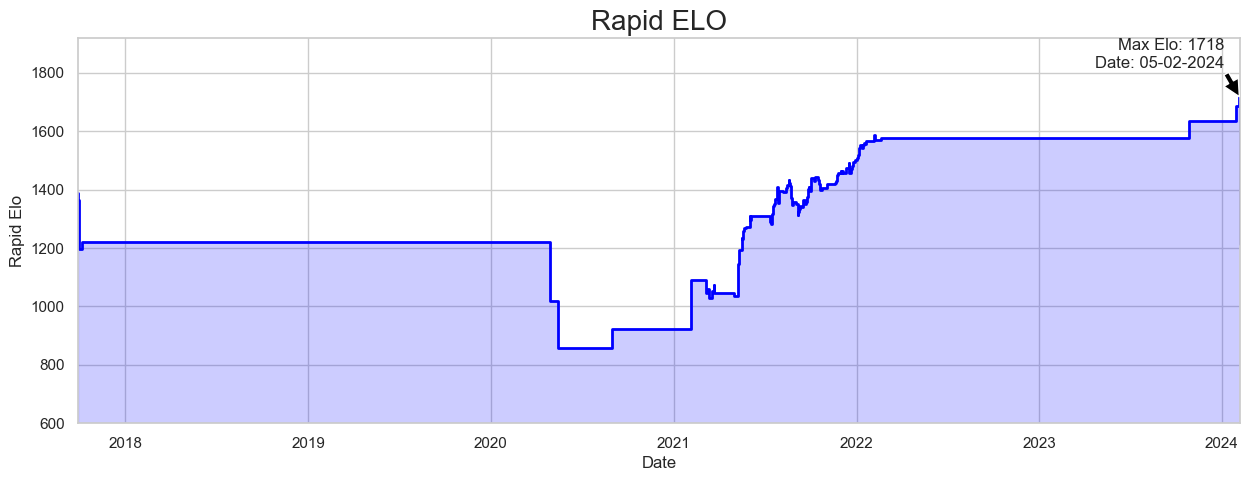

In [20]:
show_elo(rapid_elo, 'Rapid', 'blue')

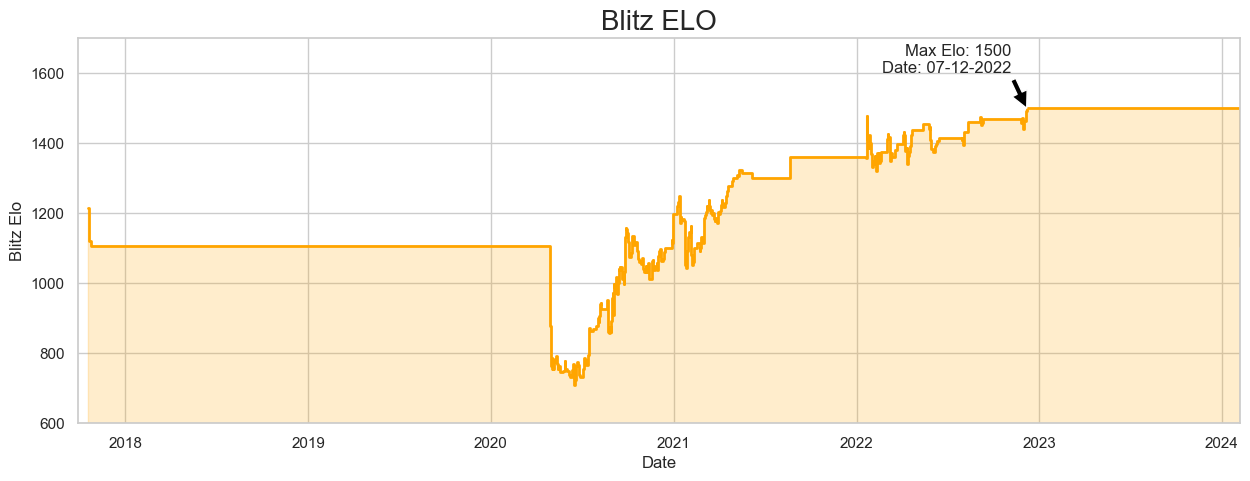

In [21]:
show_elo(blitz_elo, 'Blitz', 'orange')

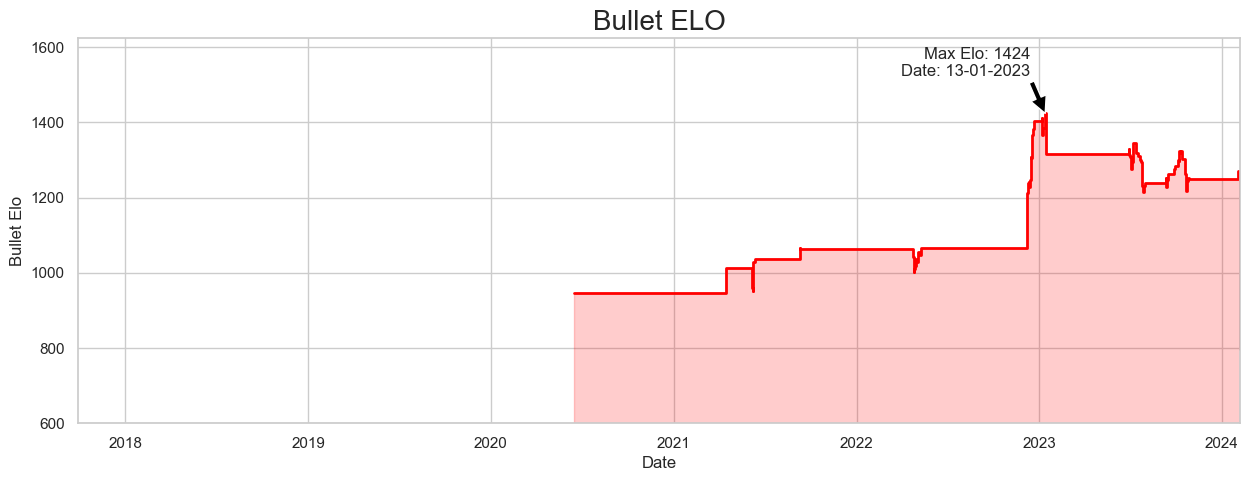

In [22]:
show_elo(bullet_elo, 'Bullet', 'red')

### Insight:
The profile was established towards the conclusion of 2017, showcasing a modest number of games. Over the subsequent two and a half years, the profile remained dormant. In April 2020, the user re-engaged, recalibrating their lowest Elo (falling below 800) at that juncture. From this point onward, a notable ascent in Elo is evident for both Blitz and Rapid time controls, extending until 2022. During this period, Bullet games were infrequently played.

Between 2022 and 2023, the user witnessed a surge in their Blitz Elo, attaining a peak of 1500 on December 7, 2022, after which no further games were played. The user then shifted their focus to Bullet games, experiencing a substantial increase—particularly noteworthy as they were initially underrated in Bullet. The peak Bullet rating of 1424 was achieved on January 13, 2023. Subsequently, the user exhibited sporadic activity, with occasional months marked by heightened participation.

At the outset of 2024, the user returned to the platform, participating in several Rapid games and achieving a pinnacle Elo of 1718 on February 5, 2024.